In [1]:
import cv2
import face_alignment
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

## 导入pretrained FA model

In [2]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False,device='cpu')

## 读取待处理图片,提取keypoint  

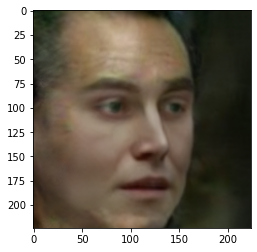

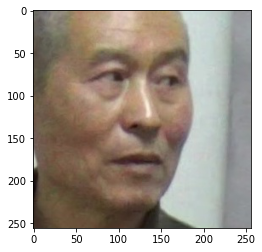

In [3]:
faceA = io.imread(r'C:\Users\houchen\faceswap_GAN\faceswap_GAN\test\faceswap.png')
faceB = io.imread(r'C:\Users\houchen\faceswap_GAN\faceswap_GAN\test\ori.jpg')

landmarks_A_ori = fa.get_landmarks(faceA)
landmarks_A = landmarks_A_ori[0]
landmarks_B_ori = fa.get_landmarks(faceB)
landmarks_B = landmarks_B_ori[0]

plt.imshow(faceA)
plt.show()
plt.imshow(faceB)
plt.show()

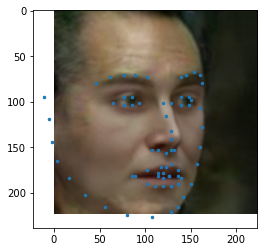

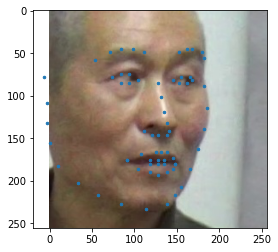

In [4]:
plt.imshow(faceA)
plt.plot(landmarks_A[:,0],landmarks_A[:,1],'.',markersize=5)
plt.show()

plt.imshow(faceB)
plt.plot(landmarks_B[:,0],landmarks_B[:,1],'.',markersize=5)
plt.show()

## 生成mask
5.10 修改：添加形态学膨胀

In [5]:
kernel = np.ones((10,10),np.uint8) 

maskA = np.zeros_like(faceA)
hullA = cv2.convexHull(np.array(landmarks_A)).astype(np.int32)
maskA = cv2.drawContours(maskA,[hullA],0,(1,1,1),-1)
#maskA = cv2.dilate(maskA,kernel)

maskB = np.zeros_like(faceB)
hullB = cv2.convexHull(np.array(landmarks_B)).astype(np.int32)
maskB = cv2.drawContours(maskB,[hullB],0,(1,1,1),-1)
#maskB = cv2.dilate(maskB,kernel)

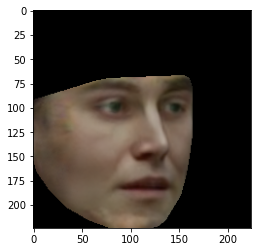

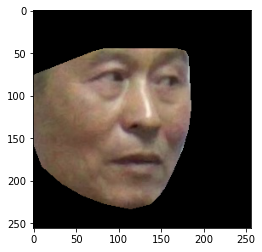

In [6]:
plt.imshow(maskA*faceA)
plt.show()
plt.imshow(maskB*faceB)
plt.show()

## RANSAC法求解Homography matrix

In [7]:
def getCenter(mask):
    ##获取mask的中心点坐标
    up, down, left ,right = 0, 0, 0, 0
    up_flag, left_flag = False, False
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i][j][0] != 0:
                if not up_flag and i > up:    
                    up = i
                    up_flag = True
                if i > down:  down = i
                if not left_flag and j < left:  
                    left = j
                    left_flag = True
                if j > right: right = j
    return ((left+right)//2,(up+down)//2)

In [8]:
homography, mask = cv2.findHomography(landmarks_A, landmarks_B, cv2.RANSAC, ransacReprojThreshold=1.0)
matchesMask = mask.ravel().tolist()

In [9]:
im_in = maskA*faceA
im_out = cv2.warpPerspective(im_in, homography, (faceB.shape[1],faceB.shape[0]))
mask_out = 255 * cv2.warpPerspective(maskA, homography, (faceB.shape[1],faceB.shape[0]))
center = getCenter(mask_out)

## 边界处理 Possion Matting+颜色处理

In [10]:
imgA = cv2.cvtColor(im_out,cv2.COLOR_RGB2YUV)
imgB = cv2.cvtColor(maskB*faceB,cv2.COLOR_RGB2YUV)
imgA[:,:,1] = imgB[:,:,1]
imgA[:,:,2] = imgB[:,:,2]
imgA = cv2.cvtColor(imgA,cv2.COLOR_YUV2RGB)

result = cv2.seamlessClone(imgA, faceB, mask_out, center, cv2.NORMAL_CLONE)

ground truth: 


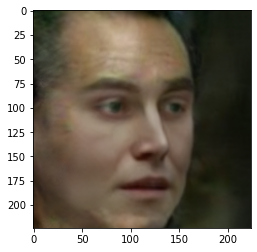

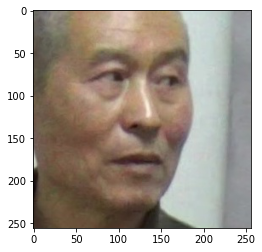

result: 


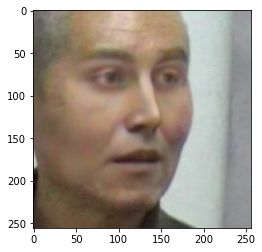

In [11]:
print('ground truth: ')
plt.imshow(faceA)
plt.show()
plt.imshow(faceB)
plt.show()

print('result: ')
plt.imshow(result)
plt.show()

## Test  

In [14]:
imgA_test = cv2.cvtColor(im_out,cv2.COLOR_RGB2YUV)
imgB_test = cv2.cvtColor(maskB*faceB,cv2.COLOR_RGB2YUV)

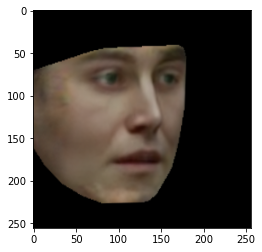

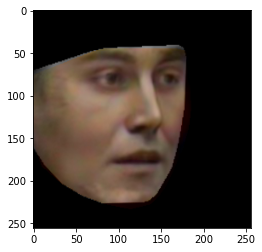

In [15]:
imgA_test[:,:,1] = imgB_test[:,:,1]
imgA_test[:,:,2] = imgB_test[:,:,2]
img = cv2.cvtColor(imgA_test,cv2.COLOR_YUV2RGB)
plt.imshow(im_out)
plt.show()
plt.imshow(img)
plt.show()